### 1. Import and Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
from PIL import Image
import glob

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seed
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


### 2. Beta-VAE Model Architecture

In [3]:
class BetaVAE(nn.Module):
    """
    Beta-VAE: Learning Basic Visual Concepts with a Constrained Variational Framework
    Higgins et al., ICLR 2017

    Key innovation: Weighted KL divergence for disentangled representations
    """

    def __init__(self, z_dim=10, beta=4.0, input_channels=1):
        super(BetaVAE, self).__init__()

        self.z_dim = z_dim
        self.beta = beta

        # Encoder
        self.encoder = nn.Sequential(
            # Input: 64x64
            nn.Conv2d(input_channels, 32, 4, 2, 1),  # 32x32
            nn.ReLU(),
            nn.Conv2d(32, 32, 4, 2, 1),  # 16x16
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),  # 8x8
            nn.ReLU(),
            nn.Conv2d(64, 64, 4, 2, 1),  # 4x4
            nn.ReLU(),
            nn.Conv2d(64, 256, 4, 1),    # 1x1
            nn.ReLU(),
            nn.Flatten()
        )

        # Latent space parameters
        self.fc_mu = nn.Linear(256, z_dim)
        self.fc_logvar = nn.Linear(256, z_dim)

        # Decoder
        self.decoder_input = nn.Linear(z_dim, 256)

        self.decoder = nn.Sequential(
            # Start: 1x1x256
            nn.ConvTranspose2d(256, 64, 4),  # 4x4
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 4, 2, 1),  # 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),  # 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 4, 2, 1),  # 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_channels, 4, 2, 1),  # 64x64
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_input(z)
        h = h.view(-1, 256, 1, 1)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

    def loss_function(self, recon_x, x, mu, logvar):
        # Reconstruction loss (binary cross entropy for images)
        recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')

        # KL divergence
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        # Beta-VAE: Weight the KL term
        total_loss = recon_loss + self.beta * kl_loss

        return total_loss, recon_loss, kl_loss

### 3. Loading Data

In [8]:
# Download dSprites dataset
import requests
import io
import pickle

def load_dsprites():
    """Load dSprites dataset"""
    dsprites_path = "dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz"

    if not os.path.exists(dsprites_path):
        print("Downloading dSprites dataset...")
        url = "https://github.com/deepmind/dsprites-dataset/raw/master/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz"
        r = requests.get(url)
        with open(dsprites_path, 'wb') as f:
            f.write(r.content)

    # Load dataset
    dataset = np.load(dsprites_path, allow_pickle=True, encoding='bytes')
    images = dataset['imgs']
    latents = dataset['latents_values']
    latents_classes = dataset['latents_classes']

    print(f"Loaded {len(images)} dSprites images")
    print(f"Latent dimensions: {latents.shape[1]}")
    print(f"Latent factors: color, shape, scale, rotation, pos_x, pos_y")

    return images, latents, latents_classes

class DSpritesDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # Add channel dim
        return img, 0  # Dummy label

# Alternative: CelebA dataset (if dSprites download fails)
def load_celeba(data_path='./celeba'):
    """Load CelebA dataset"""
    transform = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
    ])

    dataset = torchvision.datasets.CelebA(root=data_path, split='train',
                                         download=True, transform=transform)
    return dataset

### 4. Training Function

In [5]:
def train_beta_vae(model, train_loader, epochs=100, learning_rate=1e-3):
    """Train Beta-VAE model"""

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    recon_losses = []
    kl_losses = []

    model.to(device)

    print("Starting Beta-VAE Training...")
    print(f"Beta: {model.beta}, Latent dim: {model.z_dim}")
    print("=" * 60)

    for epoch in range(epochs):
        model.train()
        epoch_total_loss = 0.0
        epoch_recon_loss = 0.0
        epoch_kl_loss = 0.0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        for batch_idx, (data, _) in enumerate(pbar):
            data = data.to(device)

            optimizer.zero_grad()

            # Forward pass
            recon_batch, mu, logvar = model(data)

            # Compute loss
            total_loss, recon_loss, kl_loss = model.loss_function(recon_batch, data, mu, logvar)

            # Backward pass
            total_loss.backward()
            optimizer.step()

            epoch_total_loss += total_loss.item()
            epoch_recon_loss += recon_loss.item()
            epoch_kl_loss += kl_loss.item()

            pbar.set_postfix({
                'Total': f'{total_loss.item()/len(data):.2f}',
                'Recon': f'{recon_loss.item()/len(data):.2f}',
                'KL': f'{kl_loss.item()/len(data):.2f}'
            })

        # Calculate averages
        avg_total = epoch_total_loss / len(train_loader.dataset)
        avg_recon = epoch_recon_loss / len(train_loader.dataset)
        avg_kl = epoch_kl_loss / len(train_loader.dataset)

        train_losses.append(avg_total)
        recon_losses.append(avg_recon)
        kl_losses.append(avg_kl)

        print(f'Epoch {epoch+1}: Total: {avg_total:.2f}, Recon: {avg_recon:.2f}, KL: {avg_kl:.2f}')

    return train_losses, recon_losses, kl_losses

### 4. Latent Space Visualization

In [6]:
def latent_traversal(model, test_loader, num_samples=5, traversal_steps=11):
    """
    Perform latent space traversal to visualize disentanglement
    This is the key visualization from the Beta-VAE paper!
    """
    model.eval()

    # Get some test samples
    test_data, _ = next(iter(test_loader))
    test_data = test_data[:num_samples].to(device)

    with torch.no_grad():
        # Encode test samples
        mu, logvar = model.encode(test_data)
        z = model.reparameterize(mu, logvar)

        # Create traversal visualization
        fig, axes = plt.subplots(num_samples, traversal_steps, figsize=(15, 8))

        for sample_idx in range(num_samples):
            original_z = z[sample_idx].unsqueeze(0)

            for latent_dim in range(min(model.z_dim, traversal_steps)):
                # Create traversal range (-3 to +3 standard deviations)
                traversal_range = torch.linspace(-3, 3, traversal_steps)

                for step_idx, step_val in enumerate(traversal_range):
                    modified_z = original_z.clone()
                    modified_z[0, latent_dim] = step_val

                    # Decode traversed latent vector
                    reconstructed = model.decode(modified_z)

                    # Plot
                    if num_samples == 1:
                        ax = axes[latent_dim, step_idx]
                    else:
                        ax = axes[sample_idx, step_idx]

                    img = reconstructed.squeeze().cpu().numpy()
                    ax.imshow(img, cmap='gray')
                    ax.axis('off')

                    # Add labels for first row and column
                    if sample_idx == 0 and step_idx == traversal_steps // 2:
                        ax.set_title(f'Latent {latent_dim}', fontsize=10)
                    if latent_dim == 0 and step_idx == 0:
                        ax.set_ylabel(f'Sample {sample_idx}', fontsize=10)

        plt.suptitle(f'Beta-VAE Latent Space Traversal (β={model.beta})', fontsize=16)
        plt.tight_layout()
        plt.show()

def plot_training_curves(train_losses, recon_losses, kl_losses):
    """Plot training progress"""
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses)
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 2)
    plt.plot(recon_losses)
    plt.title('Reconstruction Loss')
    plt.xlabel('Epoch')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 3)
    plt.plot(kl_losses)
    plt.title('KL Loss')
    plt.xlabel('Epoch')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def compare_different_betas():
    """Compare different beta values for disentanglement"""
    betas = [1.0, 4.0, 10.0, 20.0]

    for beta in betas:
        print(f"\nTraining Beta-VAE with β={beta}")
        print("=" * 40)

        # Initialize model
        model = BetaVAE(z_dim=10, beta=beta)

        # Train
        train_losses, recon_losses, kl_losses = train_beta_vae(
            model, train_loader, epochs=30, learning_rate=1e-3
        )

        # Plot training
        plot_training_curves(train_losses, recon_losses, kl_losses)

        # Show latent traversal
        latent_traversal(model, test_loader, num_samples=3, traversal_steps=10)

### 6. Disentanglement metrics

In [11]:
def compute_disentanglement_metrics(model, test_loader, latents_values):
    """
    Compute quantitative disentanglement metrics
    Based on the Beta-VAE paper's metrics
    """
    model.eval()

    with torch.no_grad():
        # Sample random points from dataset
        all_mus = []
        all_latents = []

        for i, (data, _) in enumerate(test_loader):
            if i > 100:  # Use first 100 batches
                break

            data = data.to(device)
            mu, _ = model.encode(data)
            all_mus.append(mu.cpu())

            # Get corresponding latent factors
            batch_indices = range(i * test_loader.batch_size,
                                min((i + 1) * test_loader.batch_size, len(latents_values)))
            batch_latents = latents_values[batch_indices]
            all_latents.append(torch.tensor(batch_latents))

        all_mus = torch.cat(all_mus)
        all_latents = torch.cat(all_latents)

        # Compute variance explained by each latent factor
        print("Variance of latent dimensions:")
        latent_vars = torch.var(all_mus, dim=0)
        for i, var in enumerate(latent_vars):
            print(f"  Latent {i}: {var:.4f}")

        return latent_vars

def generate_random_samples(model, num_samples=25):
    """Generate new samples from random latent vectors"""
    model.eval()

    with torch.no_grad():
        # Sample from standard normal
        z = torch.randn(num_samples, model.z_dim).to(device)

        # Generate images
        generated = model.decode(z)
        generated = generated.cpu()

        # Plot in grid
        grid_size = int(np.sqrt(num_samples))
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

        for i, ax in enumerate(axes.flat):
            if i < num_samples:
                img = generated[i].squeeze().numpy()
                ax.imshow(img, cmap='gray')
            ax.axis('off')

        plt.suptitle(f'Generated Samples from Beta-VAE (β={model.beta})', fontsize=16)
        plt.tight_layout()
        plt.show()

### 7. Training

Loading dataset...
Loaded 737280 dSprites images
Latent dimensions: 6
Latent factors: color, shape, scale, rotation, pos_x, pos_y
Using dSprites dataset
Training samples: 663552
Test samples: 73728

Training Beta-VAE with β=1.0
Starting Beta-VAE Training...
Beta: 1.0, Latent dim: 10


Epoch 1/50: 100%|██████████| 5184/5184 [01:16<00:00, 67.90it/s, Total=78.22, Recon=59.51, KL=18.70]


Epoch 1: Total: 122.30, Recon: 104.88, KL: 17.42


Epoch 2/50: 100%|██████████| 5184/5184 [01:15<00:00, 69.08it/s, Total=57.98, Recon=37.14, KL=20.84]


Epoch 2: Total: 67.25, Recon: 46.98, KL: 20.27


Epoch 3/50: 100%|██████████| 5184/5184 [01:14<00:00, 69.21it/s, Total=50.07, Recon=28.72, KL=21.35]


Epoch 3: Total: 56.57, Recon: 35.34, KL: 21.23


Epoch 4/50: 100%|██████████| 5184/5184 [01:14<00:00, 69.33it/s, Total=48.91, Recon=27.62, KL=21.29]


Epoch 4: Total: 51.70, Recon: 30.14, KL: 21.55


Epoch 5/50: 100%|██████████| 5184/5184 [01:14<00:00, 69.18it/s, Total=47.93, Recon=25.99, KL=21.94]


Epoch 5: Total: 48.56, Recon: 26.85, KL: 21.71


Epoch 6/50: 100%|██████████| 5184/5184 [01:15<00:00, 68.67it/s, Total=45.66, Recon=23.80, KL=21.86]


Epoch 6: Total: 46.42, Recon: 24.61, KL: 21.81


Epoch 7/50: 100%|██████████| 5184/5184 [01:14<00:00, 69.63it/s, Total=50.01, Recon=28.20, KL=21.81]


Epoch 7: Total: 44.98, Recon: 23.12, KL: 21.86


Epoch 8/50: 100%|██████████| 5184/5184 [01:14<00:00, 69.31it/s, Total=46.01, Recon=23.85, KL=22.16]


Epoch 8: Total: 43.84, Recon: 21.96, KL: 21.88


Epoch 9/50: 100%|██████████| 5184/5184 [01:14<00:00, 69.51it/s, Total=43.09, Recon=20.95, KL=22.14]


Epoch 9: Total: 42.96, Recon: 21.07, KL: 21.89


Epoch 10/50: 100%|██████████| 5184/5184 [01:15<00:00, 68.65it/s, Total=41.66, Recon=20.12, KL=21.54]


Epoch 10: Total: 42.30, Recon: 20.43, KL: 21.87


Epoch 11/50: 100%|██████████| 5184/5184 [01:14<00:00, 69.23it/s, Total=41.10, Recon=19.01, KL=22.09]


Epoch 11: Total: 41.66, Recon: 19.80, KL: 21.86


Epoch 12/50: 100%|██████████| 5184/5184 [01:14<00:00, 69.22it/s, Total=41.49, Recon=19.72, KL=21.77]


Epoch 12: Total: 41.19, Recon: 19.35, KL: 21.85


Epoch 13/50: 100%|██████████| 5184/5184 [01:14<00:00, 69.31it/s, Total=41.07, Recon=19.48, KL=21.59]


Epoch 13: Total: 40.81, Recon: 19.00, KL: 21.82


Epoch 14/50: 100%|██████████| 5184/5184 [01:14<00:00, 69.41it/s, Total=39.84, Recon=18.06, KL=21.79]


Epoch 14: Total: 40.36, Recon: 18.55, KL: 21.81


Epoch 15/50: 100%|██████████| 5184/5184 [01:14<00:00, 69.18it/s, Total=40.28, Recon=18.41, KL=21.87]


Epoch 15: Total: 40.03, Recon: 18.24, KL: 21.78


Epoch 16/50: 100%|██████████| 5184/5184 [01:14<00:00, 69.14it/s, Total=39.74, Recon=18.55, KL=21.19]


Epoch 16: Total: 39.74, Recon: 17.99, KL: 21.75


Epoch 17/50: 100%|██████████| 5184/5184 [01:14<00:00, 69.24it/s, Total=38.30, Recon=16.62, KL=21.68]


Epoch 17: Total: 39.43, Recon: 17.69, KL: 21.74


Epoch 18/50: 100%|██████████| 5184/5184 [01:15<00:00, 68.84it/s, Total=37.74, Recon=16.34, KL=21.40]


Epoch 18: Total: 39.20, Recon: 17.49, KL: 21.71


Epoch 19/50: 100%|██████████| 5184/5184 [01:16<00:00, 67.61it/s, Total=38.47, Recon=17.13, KL=21.33]


Epoch 19: Total: 38.96, Recon: 17.28, KL: 21.68


Epoch 20/50: 100%|██████████| 5184/5184 [01:17<00:00, 67.10it/s, Total=37.93, Recon=16.37, KL=21.56]


Epoch 20: Total: 38.77, Recon: 17.11, KL: 21.67


Epoch 21/50: 100%|██████████| 5184/5184 [01:17<00:00, 67.07it/s, Total=36.62, Recon=14.99, KL=21.63]


Epoch 21: Total: 38.52, Recon: 16.88, KL: 21.64


Epoch 22/50: 100%|██████████| 5184/5184 [01:17<00:00, 67.28it/s, Total=37.69, Recon=16.20, KL=21.50]


Epoch 22: Total: 38.39, Recon: 16.78, KL: 21.62


Epoch 23/50: 100%|██████████| 5184/5184 [01:16<00:00, 67.57it/s, Total=38.93, Recon=17.49, KL=21.44]


Epoch 23: Total: 38.20, Recon: 16.61, KL: 21.59


Epoch 24/50: 100%|██████████| 5184/5184 [01:17<00:00, 67.00it/s, Total=36.73, Recon=15.44, KL=21.29]


Epoch 24: Total: 38.03, Recon: 16.47, KL: 21.56


Epoch 25/50: 100%|██████████| 5184/5184 [01:16<00:00, 67.33it/s, Total=36.98, Recon=15.82, KL=21.16]


Epoch 25: Total: 37.89, Recon: 16.34, KL: 21.55


Epoch 26/50: 100%|██████████| 5184/5184 [01:17<00:00, 67.22it/s, Total=36.70, Recon=15.13, KL=21.58]


Epoch 26: Total: 37.74, Recon: 16.22, KL: 21.52


Epoch 27/50: 100%|██████████| 5184/5184 [01:17<00:00, 67.14it/s, Total=38.86, Recon=16.83, KL=22.03]


Epoch 27: Total: 37.59, Recon: 16.09, KL: 21.50


Epoch 28/50: 100%|██████████| 5184/5184 [01:17<00:00, 67.13it/s, Total=36.63, Recon=15.11, KL=21.52]


Epoch 28: Total: 37.46, Recon: 15.97, KL: 21.48


Epoch 29/50: 100%|██████████| 5184/5184 [01:17<00:00, 67.32it/s, Total=36.94, Recon=15.74, KL=21.20]


Epoch 29: Total: 37.36, Recon: 15.90, KL: 21.46


Epoch 30/50: 100%|██████████| 5184/5184 [01:16<00:00, 67.36it/s, Total=37.51, Recon=16.00, KL=21.51]


Epoch 30: Total: 37.20, Recon: 15.76, KL: 21.44


Epoch 31/50: 100%|██████████| 5184/5184 [01:16<00:00, 67.46it/s, Total=37.30, Recon=15.56, KL=21.74]


Epoch 31: Total: 37.09, Recon: 15.68, KL: 21.41


Epoch 32/50: 100%|██████████| 5184/5184 [01:17<00:00, 67.08it/s, Total=37.88, Recon=16.00, KL=21.88]


Epoch 32: Total: 36.99, Recon: 15.59, KL: 21.39


Epoch 33/50: 100%|██████████| 5184/5184 [01:17<00:00, 67.32it/s, Total=38.04, Recon=16.53, KL=21.52]


Epoch 33: Total: 36.89, Recon: 15.52, KL: 21.37


Epoch 34/50: 100%|██████████| 5184/5184 [01:17<00:00, 67.24it/s, Total=36.40, Recon=15.09, KL=21.32]


Epoch 34: Total: 36.77, Recon: 15.42, KL: 21.35


Epoch 35/50: 100%|██████████| 5184/5184 [01:17<00:00, 67.28it/s, Total=37.03, Recon=15.84, KL=21.20]


Epoch 35: Total: 36.72, Recon: 15.40, KL: 21.32


Epoch 36/50: 100%|██████████| 5184/5184 [01:16<00:00, 67.49it/s, Total=36.05, Recon=14.78, KL=21.27]


Epoch 36: Total: 36.64, Recon: 15.32, KL: 21.31


Epoch 37/50: 100%|██████████| 5184/5184 [01:17<00:00, 66.85it/s, Total=36.90, Recon=15.72, KL=21.18]


Epoch 37: Total: 36.56, Recon: 15.27, KL: 21.29


Epoch 38/50: 100%|██████████| 5184/5184 [01:17<00:00, 67.18it/s, Total=37.79, Recon=16.56, KL=21.23]


Epoch 38: Total: 36.45, Recon: 15.19, KL: 21.27


Epoch 39/50: 100%|██████████| 5184/5184 [01:16<00:00, 67.47it/s, Total=36.76, Recon=15.51, KL=21.24]


Epoch 39: Total: 36.39, Recon: 15.13, KL: 21.26


Epoch 40/50: 100%|██████████| 5184/5184 [01:16<00:00, 67.72it/s, Total=35.43, Recon=14.54, KL=20.89]


Epoch 40: Total: 36.26, Recon: 15.02, KL: 21.24


Epoch 41/50: 100%|██████████| 5184/5184 [01:17<00:00, 67.05it/s, Total=37.28, Recon=15.74, KL=21.54]


Epoch 41: Total: 36.24, Recon: 15.01, KL: 21.23


Epoch 42/50: 100%|██████████| 5184/5184 [01:17<00:00, 67.14it/s, Total=37.00, Recon=15.62, KL=21.38]


Epoch 42: Total: 36.15, Recon: 14.96, KL: 21.20


Epoch 43/50: 100%|██████████| 5184/5184 [01:16<00:00, 67.39it/s, Total=36.56, Recon=15.12, KL=21.44]


Epoch 43: Total: 36.07, Recon: 14.88, KL: 21.19


Epoch 44/50: 100%|██████████| 5184/5184 [01:17<00:00, 67.32it/s, Total=35.04, Recon=13.71, KL=21.33]


Epoch 44: Total: 36.03, Recon: 14.85, KL: 21.17


Epoch 45/50: 100%|██████████| 5184/5184 [01:15<00:00, 68.60it/s, Total=37.02, Recon=15.55, KL=21.46]


Epoch 45: Total: 35.98, Recon: 14.82, KL: 21.16


Epoch 46/50: 100%|██████████| 5184/5184 [01:15<00:00, 69.02it/s, Total=35.68, Recon=14.62, KL=21.06]


Epoch 46: Total: 35.88, Recon: 14.73, KL: 21.15


Epoch 47/50: 100%|██████████| 5184/5184 [01:14<00:00, 69.20it/s, Total=34.63, Recon=13.58, KL=21.06]


Epoch 47: Total: 35.83, Recon: 14.68, KL: 21.14


Epoch 48/50: 100%|██████████| 5184/5184 [01:15<00:00, 69.02it/s, Total=34.99, Recon=13.86, KL=21.13]


Epoch 48: Total: 35.78, Recon: 14.64, KL: 21.13


Epoch 49/50: 100%|██████████| 5184/5184 [01:15<00:00, 69.01it/s, Total=36.77, Recon=15.47, KL=21.31]


Epoch 49: Total: 35.74, Recon: 14.62, KL: 21.12


Epoch 50/50: 100%|██████████| 5184/5184 [01:15<00:00, 68.50it/s, Total=35.72, Recon=14.73, KL=20.98]


Epoch 50: Total: 35.70, Recon: 14.58, KL: 21.12


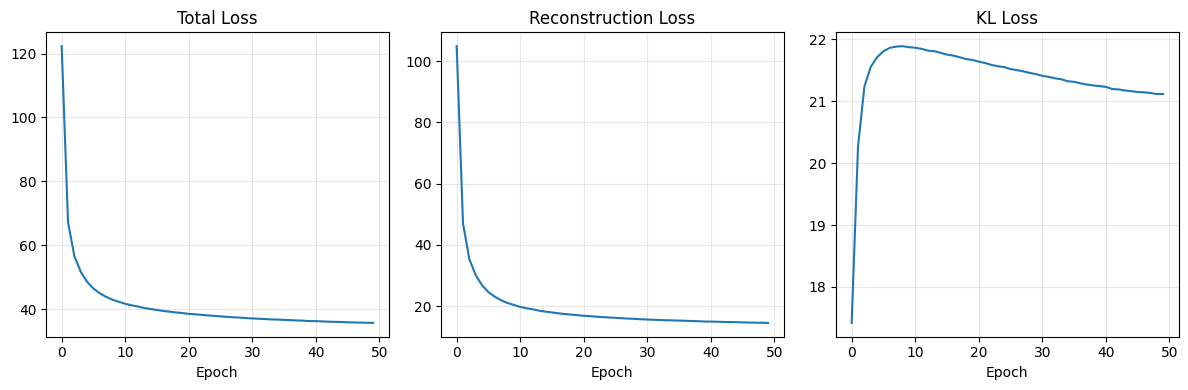

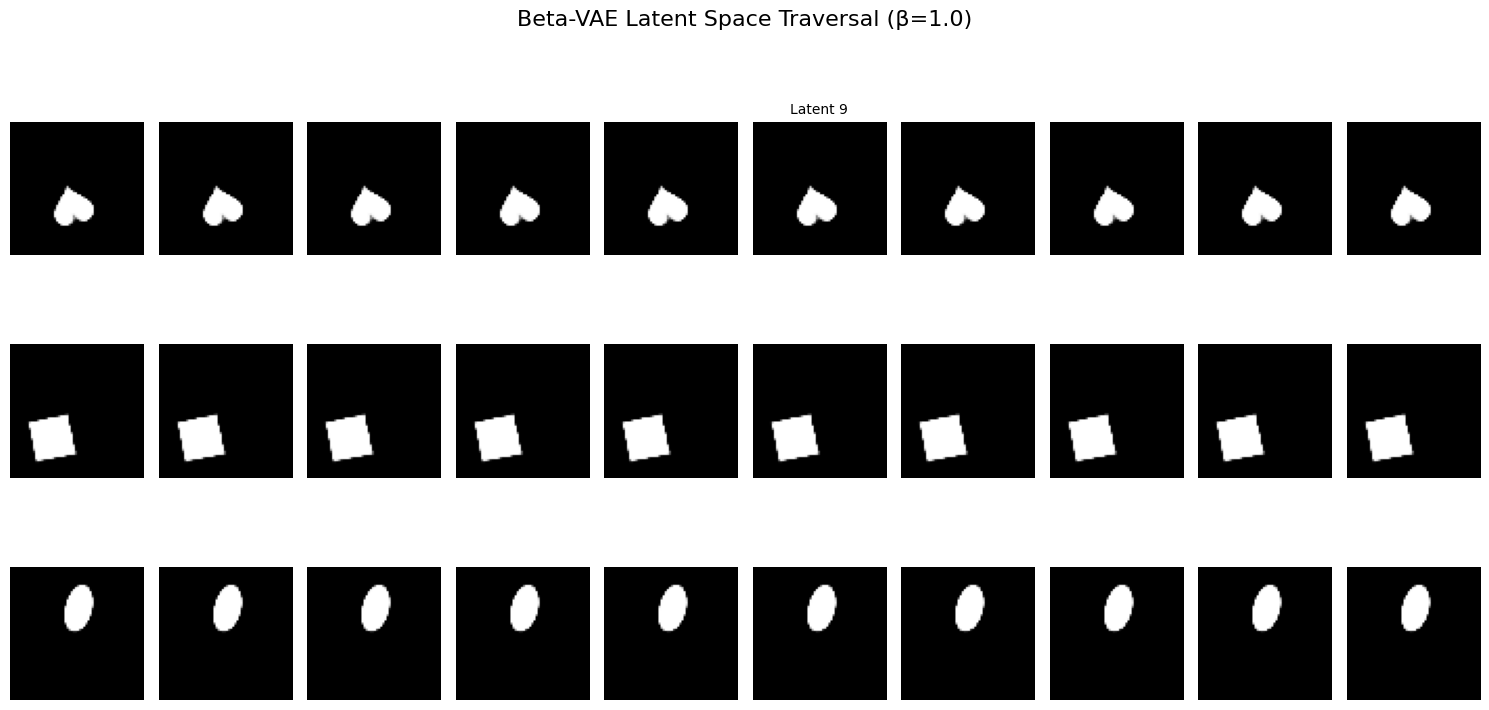

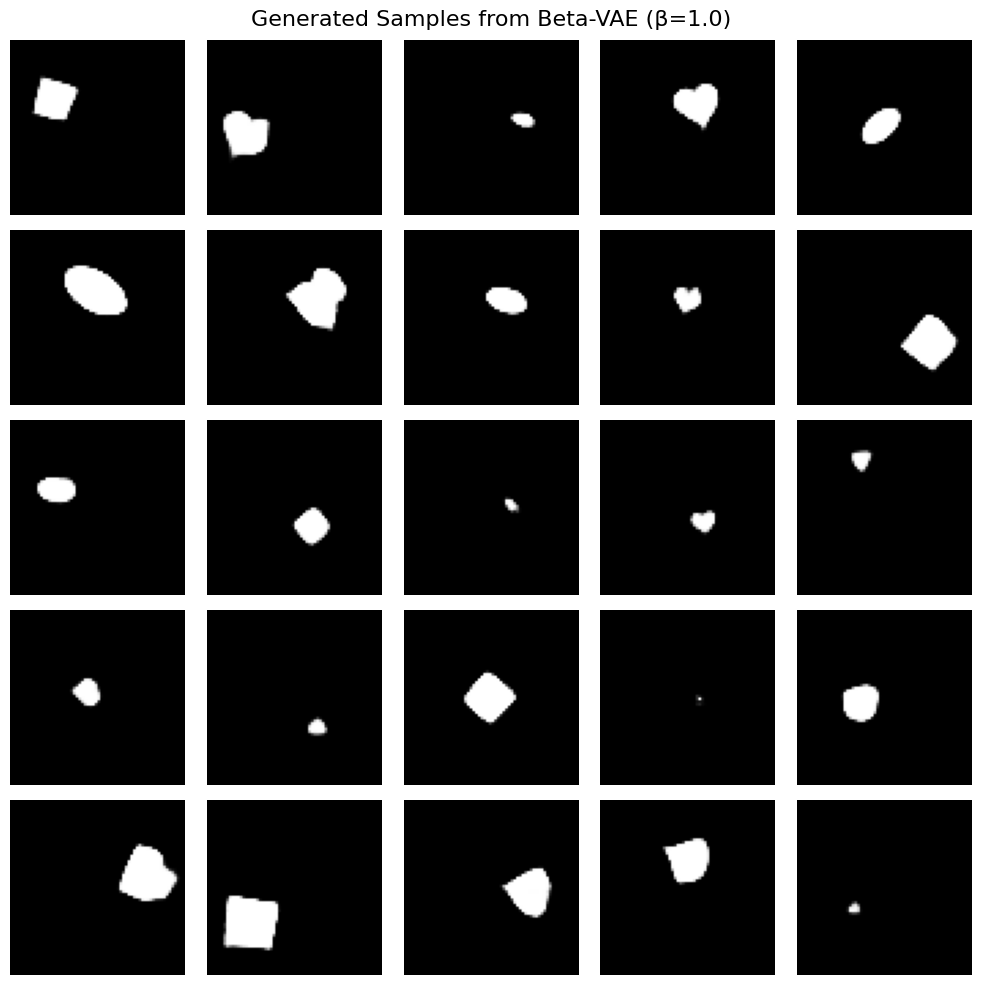

Variance of latent dimensions:
  Latent 0: 0.6690
  Latent 1: 0.9825
  Latent 2: 0.9837
  Latent 3: 0.0003
  Latent 4: 1.1621
  Latent 5: 1.1791
  Latent 6: 1.0038
  Latent 7: 0.7069
  Latent 8: 0.0002
  Latent 9: 0.0001

Training Beta-VAE with β=4.0
Starting Beta-VAE Training...
Beta: 4.0, Latent dim: 10


Epoch 1/50: 100%|██████████| 5184/5184 [01:17<00:00, 67.19it/s, Total=144.52, Recon=109.93, KL=8.65]


Epoch 1: Total: 194.05, Recon: 162.84, KL: 7.80


Epoch 2/50: 100%|██████████| 5184/5184 [01:16<00:00, 67.35it/s, Total=135.34, Recon=101.37, KL=8.49]


Epoch 2: Total: 139.89, Recon: 106.23, KL: 8.42


Epoch 3/50: 100%|██████████| 5184/5184 [01:16<00:00, 67.68it/s, Total=140.46, Recon=106.68, KL=8.44]


Epoch 3: Total: 138.86, Recon: 105.30, KL: 8.39


Epoch 4/50: 100%|██████████| 5184/5184 [01:16<00:00, 67.99it/s, Total=131.02, Recon=91.81, KL=9.80]


Epoch 4: Total: 130.75, Recon: 92.94, KL: 9.45


Epoch 5/50: 100%|██████████| 5184/5184 [01:16<00:00, 67.69it/s, Total=128.69, Recon=89.48, KL=9.80]


Epoch 5: Total: 128.05, Recon: 89.35, KL: 9.68


Epoch 6/50: 100%|██████████| 5184/5184 [01:16<00:00, 68.00it/s, Total=114.24, Recon=67.39, KL=11.71]


Epoch 6: Total: 122.16, Recon: 80.32, KL: 10.46


Epoch 7/50: 100%|██████████| 5184/5184 [01:16<00:00, 67.59it/s, Total=109.13, Recon=60.94, KL=12.05]


Epoch 7: Total: 109.95, Recon: 63.04, KL: 11.73


Epoch 8/50: 100%|██████████| 5184/5184 [01:17<00:00, 67.26it/s, Total=105.55, Recon=56.01, KL=12.38]


Epoch 8: Total: 105.33, Recon: 56.51, KL: 12.20


Epoch 9/50: 100%|██████████| 5184/5184 [01:17<00:00, 66.79it/s, Total=103.05, Recon=53.15, KL=12.48]


Epoch 9: Total: 103.32, Recon: 53.52, KL: 12.45


Epoch 10/50: 100%|██████████| 5184/5184 [01:17<00:00, 67.30it/s, Total=100.12, Recon=48.21, KL=12.98]


Epoch 10: Total: 101.78, Recon: 51.15, KL: 12.66


Epoch 11/50: 100%|██████████| 5184/5184 [01:17<00:00, 67.07it/s, Total=97.63, Recon=46.53, KL=12.77]


Epoch 11: Total: 100.37, Recon: 49.01, KL: 12.84


Epoch 12/50: 100%|██████████| 5184/5184 [01:16<00:00, 67.80it/s, Total=98.27, Recon=46.32, KL=12.99]


Epoch 12: Total: 99.31, Recon: 47.43, KL: 12.97


Epoch 13/50: 100%|██████████| 5184/5184 [01:18<00:00, 66.35it/s, Total=99.90, Recon=45.82, KL=13.52]


Epoch 13: Total: 98.49, Recon: 46.17, KL: 13.08


Epoch 14/50: 100%|██████████| 5184/5184 [01:17<00:00, 66.52it/s, Total=98.78, Recon=45.69, KL=13.27]


Epoch 14: Total: 97.76, Recon: 45.01, KL: 13.19


Epoch 15/50: 100%|██████████| 5184/5184 [01:16<00:00, 67.62it/s, Total=95.14, Recon=43.73, KL=12.85]


Epoch 15: Total: 97.17, Recon: 43.99, KL: 13.30


Epoch 16/50: 100%|██████████| 5184/5184 [01:16<00:00, 67.76it/s, Total=94.63, Recon=41.47, KL=13.29]


Epoch 16: Total: 96.54, Recon: 42.93, KL: 13.40


Epoch 17/50: 100%|██████████| 5184/5184 [01:17<00:00, 67.15it/s, Total=94.50, Recon=41.03, KL=13.37]


Epoch 17: Total: 96.01, Recon: 42.05, KL: 13.49


Epoch 18/50: 100%|██████████| 5184/5184 [01:16<00:00, 68.00it/s, Total=94.18, Recon=40.15, KL=13.51]


Epoch 18: Total: 95.54, Recon: 41.24, KL: 13.57


Epoch 19/50: 100%|██████████| 5184/5184 [01:16<00:00, 67.92it/s, Total=95.48, Recon=41.38, KL=13.52]


Epoch 19: Total: 95.08, Recon: 40.51, KL: 13.64


Epoch 20/50: 100%|██████████| 5184/5184 [01:16<00:00, 67.75it/s, Total=92.22, Recon=38.04, KL=13.54]


Epoch 20: Total: 94.70, Recon: 39.91, KL: 13.70


Epoch 21/50: 100%|██████████| 5184/5184 [01:16<00:00, 67.35it/s, Total=92.58, Recon=37.54, KL=13.76]


Epoch 21: Total: 94.25, Recon: 39.22, KL: 13.76


Epoch 22/50: 100%|██████████| 5184/5184 [01:17<00:00, 67.07it/s, Total=91.90, Recon=37.27, KL=13.66]


Epoch 22: Total: 93.92, Recon: 38.67, KL: 13.81


Epoch 23/50: 100%|██████████| 5184/5184 [01:17<00:00, 67.12it/s, Total=92.90, Recon=37.82, KL=13.77]


Epoch 23: Total: 93.71, Recon: 38.34, KL: 13.84


Epoch 24/50: 100%|██████████| 5184/5184 [01:16<00:00, 67.93it/s, Total=93.98, Recon=38.77, KL=13.80]


Epoch 24: Total: 93.37, Recon: 37.83, KL: 13.88


Epoch 25/50: 100%|██████████| 5184/5184 [01:17<00:00, 67.25it/s, Total=93.71, Recon=37.12, KL=14.15]


Epoch 25: Total: 93.12, Recon: 37.45, KL: 13.92


Epoch 26/50: 100%|██████████| 5184/5184 [01:17<00:00, 67.28it/s, Total=90.82, Recon=35.47, KL=13.84]


Epoch 26: Total: 92.90, Recon: 37.10, KL: 13.95


Epoch 27/50: 100%|██████████| 5184/5184 [01:17<00:00, 67.11it/s, Total=91.65, Recon=36.15, KL=13.88]


Epoch 27: Total: 92.69, Recon: 36.77, KL: 13.98


Epoch 28/50: 100%|██████████| 5184/5184 [01:16<00:00, 67.56it/s, Total=93.79, Recon=37.12, KL=14.17]


Epoch 28: Total: 92.53, Recon: 36.50, KL: 14.01


Epoch 29/50: 100%|██████████| 5184/5184 [01:17<00:00, 67.10it/s, Total=92.86, Recon=36.85, KL=14.00]


Epoch 29: Total: 92.31, Recon: 36.16, KL: 14.04


Epoch 30/50: 100%|██████████| 5184/5184 [01:17<00:00, 67.14it/s, Total=94.16, Recon=37.68, KL=14.12]


Epoch 30: Total: 92.06, Recon: 35.81, KL: 14.06


Epoch 31/50: 100%|██████████| 5184/5184 [01:17<00:00, 67.01it/s, Total=92.20, Recon=34.35, KL=14.46]


Epoch 31: Total: 91.89, Recon: 35.55, KL: 14.08


Epoch 32/50: 100%|██████████| 5184/5184 [01:16<00:00, 67.37it/s, Total=91.48, Recon=35.42, KL=14.01]


Epoch 32: Total: 91.73, Recon: 35.28, KL: 14.11


Epoch 33/50: 100%|██████████| 5184/5184 [01:18<00:00, 66.43it/s, Total=90.97, Recon=33.88, KL=14.27]


Epoch 33: Total: 91.56, Recon: 35.00, KL: 14.14


Epoch 34/50: 100%|██████████| 5184/5184 [01:16<00:00, 67.37it/s, Total=91.47, Recon=34.46, KL=14.25]


Epoch 34: Total: 91.39, Recon: 34.74, KL: 14.16


Epoch 35/50: 100%|██████████| 5184/5184 [01:16<00:00, 67.89it/s, Total=91.69, Recon=34.37, KL=14.33]


Epoch 35: Total: 91.26, Recon: 34.47, KL: 14.20


Epoch 36/50: 100%|██████████| 5184/5184 [01:16<00:00, 67.76it/s, Total=90.86, Recon=33.37, KL=14.37]


Epoch 36: Total: 91.04, Recon: 34.15, KL: 14.22


Epoch 37/50: 100%|██████████| 5184/5184 [01:17<00:00, 67.04it/s, Total=89.83, Recon=32.92, KL=14.23]


Epoch 37: Total: 90.95, Recon: 33.97, KL: 14.24


Epoch 38/50: 100%|██████████| 5184/5184 [01:17<00:00, 67.21it/s, Total=91.59, Recon=34.43, KL=14.29]


Epoch 38: Total: 90.83, Recon: 33.77, KL: 14.27


Epoch 39/50: 100%|██████████| 5184/5184 [01:16<00:00, 67.94it/s, Total=89.85, Recon=33.24, KL=14.15]


Epoch 39: Total: 90.70, Recon: 33.51, KL: 14.30


Epoch 40/50: 100%|██████████| 5184/5184 [01:16<00:00, 67.97it/s, Total=91.98, Recon=33.01, KL=14.74]


Epoch 40: Total: 90.55, Recon: 33.33, KL: 14.30


Epoch 41/50: 100%|██████████| 5184/5184 [01:16<00:00, 67.38it/s, Total=92.08, Recon=34.92, KL=14.29]


Epoch 41: Total: 90.44, Recon: 33.13, KL: 14.33


Epoch 42/50: 100%|██████████| 5184/5184 [01:16<00:00, 68.05it/s, Total=90.84, Recon=33.49, KL=14.34]


Epoch 42: Total: 90.29, Recon: 32.90, KL: 14.35


Epoch 43/50: 100%|██████████| 5184/5184 [01:16<00:00, 67.73it/s, Total=90.76, Recon=33.90, KL=14.21]


Epoch 43: Total: 90.20, Recon: 32.74, KL: 14.37


Epoch 44/50: 100%|██████████| 5184/5184 [01:16<00:00, 67.52it/s, Total=87.55, Recon=30.38, KL=14.29]


Epoch 44: Total: 90.02, Recon: 32.48, KL: 14.39


Epoch 45/50: 100%|██████████| 5184/5184 [01:17<00:00, 66.97it/s, Total=89.82, Recon=32.29, KL=14.38]


Epoch 45: Total: 89.96, Recon: 32.35, KL: 14.40


Epoch 46/50: 100%|██████████| 5184/5184 [01:17<00:00, 66.84it/s, Total=90.30, Recon=31.58, KL=14.68]


Epoch 46: Total: 89.85, Recon: 32.20, KL: 14.41


Epoch 47/50: 100%|██████████| 5184/5184 [01:17<00:00, 66.57it/s, Total=87.23, Recon=29.74, KL=14.37]


Epoch 47: Total: 89.73, Recon: 32.04, KL: 14.42


Epoch 48/50: 100%|██████████| 5184/5184 [01:17<00:00, 66.90it/s, Total=90.72, Recon=32.84, KL=14.47]


Epoch 48: Total: 89.65, Recon: 31.86, KL: 14.45


Epoch 49/50: 100%|██████████| 5184/5184 [01:18<00:00, 66.38it/s, Total=87.44, Recon=30.01, KL=14.36]


Epoch 49: Total: 89.54, Recon: 31.74, KL: 14.45


Epoch 50/50: 100%|██████████| 5184/5184 [01:17<00:00, 66.72it/s, Total=87.14, Recon=29.02, KL=14.53]


Epoch 50: Total: 89.45, Recon: 31.61, KL: 14.46


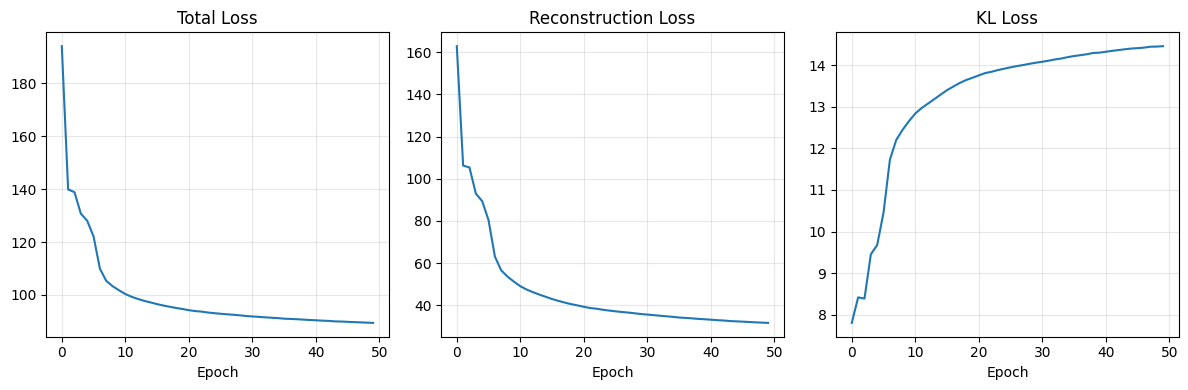

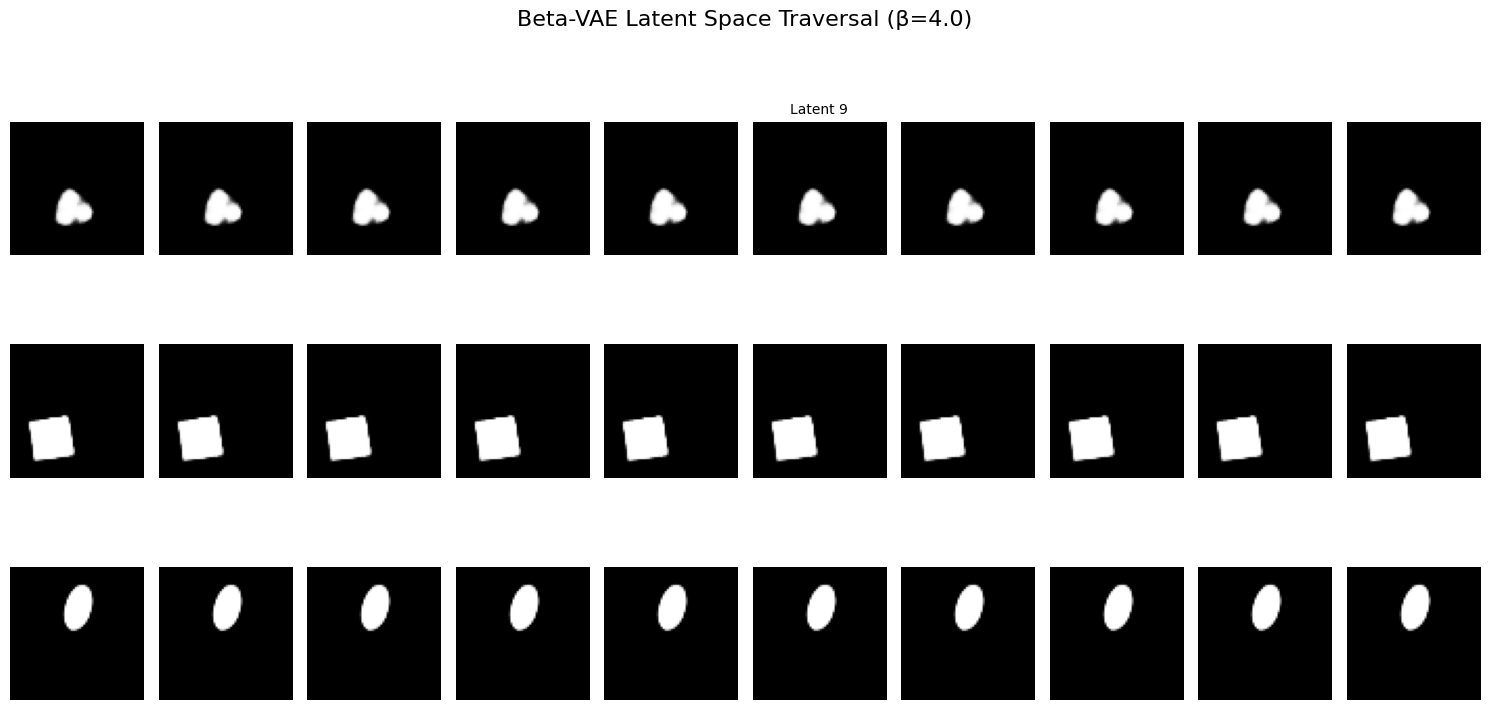

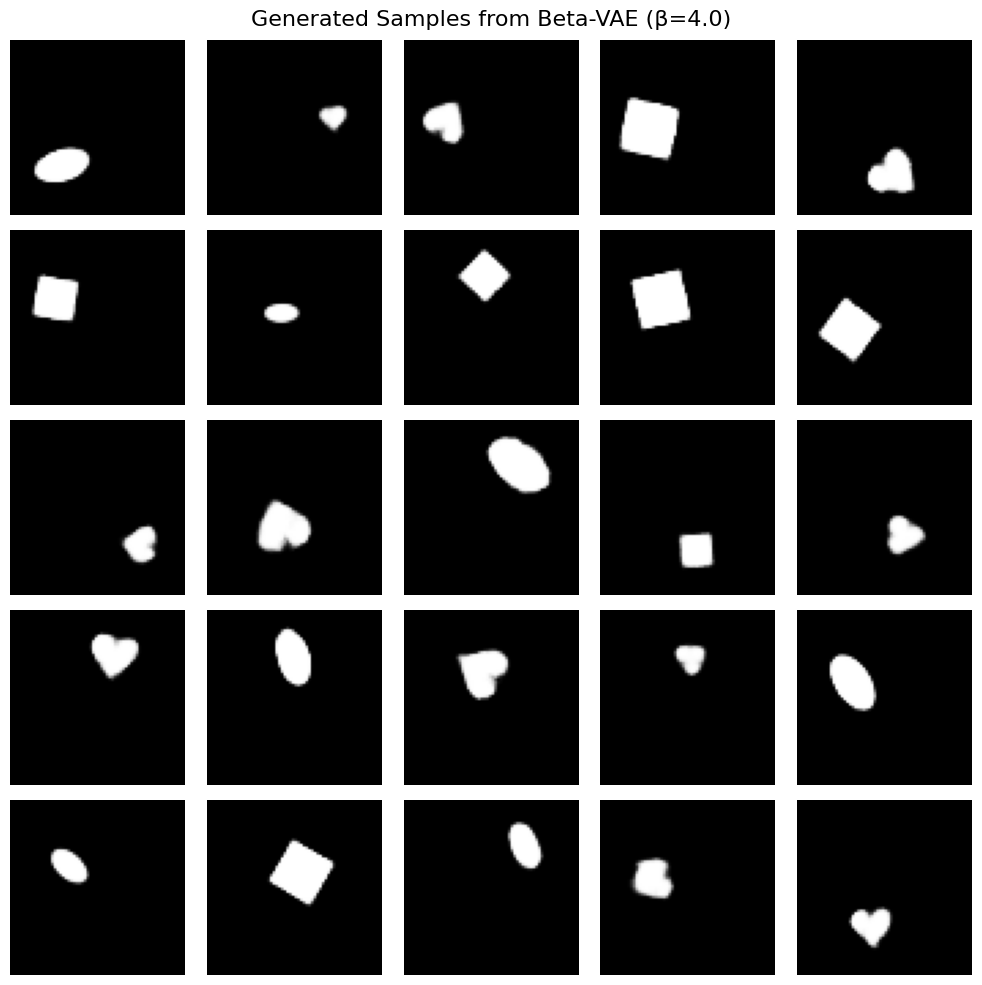

Variance of latent dimensions:
  Latent 0: 0.0000
  Latent 1: 0.0001
  Latent 2: 1.0149
  Latent 3: 0.9841
  Latent 4: 0.0001
  Latent 5: 0.0000
  Latent 6: 1.0552
  Latent 7: 1.0042
  Latent 8: 1.0422
  Latent 9: 0.0001

Training Beta-VAE with β=10.0
Starting Beta-VAE Training...
Beta: 10.0, Latent dim: 10


Epoch 1/50: 100%|██████████| 5184/5184 [01:18<00:00, 66.06it/s, Total=188.25, Recon=113.08, KL=7.52]


Epoch 1: Total: 211.30, Recon: 140.82, KL: 7.05


Epoch 2/50: 100%|██████████| 5184/5184 [01:18<00:00, 66.20it/s, Total=185.65, Recon=112.63, KL=7.30]


Epoch 2: Total: 185.17, Recon: 111.12, KL: 7.41


Epoch 3/50: 100%|██████████| 5184/5184 [01:19<00:00, 65.61it/s, Total=177.87, Recon=103.38, KL=7.45]


Epoch 3: Total: 181.62, Recon: 108.57, KL: 7.31


Epoch 4/50: 100%|██████████| 5184/5184 [01:17<00:00, 66.51it/s, Total=185.38, Recon=103.81, KL=8.16]


Epoch 4: Total: 179.17, Recon: 103.98, KL: 7.52


Epoch 5/50: 100%|██████████| 5184/5184 [01:18<00:00, 66.34it/s, Total=175.49, Recon=92.86, KL=8.26]


Epoch 5: Total: 174.76, Recon: 94.07, KL: 8.07


Epoch 6/50: 100%|██████████| 5184/5184 [01:17<00:00, 66.99it/s, Total=168.66, Recon=90.40, KL=7.83]


Epoch 6: Total: 173.43, Recon: 92.01, KL: 8.14


Epoch 7/50: 100%|██████████| 5184/5184 [01:18<00:00, 66.23it/s, Total=176.81, Recon=93.90, KL=8.29]


Epoch 7: Total: 172.70, Recon: 90.94, KL: 8.18


Epoch 8/50: 100%|██████████| 5184/5184 [01:17<00:00, 66.70it/s, Total=171.19, Recon=89.27, KL=8.19]


Epoch 8: Total: 172.25, Recon: 90.16, KL: 8.21


Epoch 9/50: 100%|██████████| 5184/5184 [01:17<00:00, 66.75it/s, Total=180.02, Recon=96.17, KL=8.39]


Epoch 9: Total: 171.85, Recon: 89.67, KL: 8.22


Epoch 10/50: 100%|██████████| 5184/5184 [01:18<00:00, 66.34it/s, Total=172.31, Recon=85.56, KL=8.67]


Epoch 10: Total: 171.27, Recon: 88.48, KL: 8.28


Epoch 11/50: 100%|██████████| 5184/5184 [01:18<00:00, 65.88it/s, Total=172.96, Recon=85.48, KL=8.75]


Epoch 11: Total: 169.50, Recon: 84.74, KL: 8.48


Epoch 12/50: 100%|██████████| 5184/5184 [01:18<00:00, 66.35it/s, Total=167.16, Recon=79.44, KL=8.77]


Epoch 12: Total: 167.49, Recon: 81.06, KL: 8.64


Epoch 13/50: 100%|██████████| 5184/5184 [01:18<00:00, 66.15it/s, Total=167.56, Recon=84.68, KL=8.29]


Epoch 13: Total: 166.82, Recon: 80.00, KL: 8.68


Epoch 14/50: 100%|██████████| 5184/5184 [01:18<00:00, 65.73it/s, Total=159.88, Recon=72.07, KL=8.78]


Epoch 14: Total: 166.37, Recon: 79.20, KL: 8.72


Epoch 15/50: 100%|██████████| 5184/5184 [01:19<00:00, 65.05it/s, Total=167.67, Recon=78.08, KL=8.96]


Epoch 15: Total: 166.01, Recon: 78.64, KL: 8.74


Epoch 16/50: 100%|██████████| 5184/5184 [01:18<00:00, 65.68it/s, Total=171.02, Recon=80.93, KL=9.01]


Epoch 16: Total: 165.78, Recon: 78.21, KL: 8.76


Epoch 17/50: 100%|██████████| 5184/5184 [01:17<00:00, 66.59it/s, Total=166.16, Recon=78.61, KL=8.76]


Epoch 17: Total: 165.63, Recon: 77.82, KL: 8.78


Epoch 18/50: 100%|██████████| 5184/5184 [01:18<00:00, 65.85it/s, Total=165.12, Recon=74.47, KL=9.06]


Epoch 18: Total: 165.40, Recon: 77.37, KL: 8.80


Epoch 19/50: 100%|██████████| 5184/5184 [01:18<00:00, 66.16it/s, Total=167.92, Recon=77.96, KL=9.00]


Epoch 19: Total: 165.32, Recon: 77.11, KL: 8.82


Epoch 20/50: 100%|██████████| 5184/5184 [01:17<00:00, 66.80it/s, Total=165.30, Recon=76.04, KL=8.93]


Epoch 20: Total: 165.11, Recon: 76.74, KL: 8.84


Epoch 21/50: 100%|██████████| 5184/5184 [01:18<00:00, 66.16it/s, Total=166.28, Recon=77.66, KL=8.86]


Epoch 21: Total: 164.99, Recon: 76.20, KL: 8.88


Epoch 22/50: 100%|██████████| 5184/5184 [01:18<00:00, 65.95it/s, Total=164.49, Recon=76.85, KL=8.76]


Epoch 22: Total: 164.83, Recon: 75.84, KL: 8.90


Epoch 23/50: 100%|██████████| 5184/5184 [01:18<00:00, 66.25it/s, Total=170.77, Recon=82.09, KL=8.87]


Epoch 23: Total: 164.73, Recon: 75.20, KL: 8.95


Epoch 24/50: 100%|██████████| 5184/5184 [01:18<00:00, 66.39it/s, Total=163.24, Recon=74.61, KL=8.86]


Epoch 24: Total: 164.44, Recon: 74.55, KL: 8.99


Epoch 25/50: 100%|██████████| 5184/5184 [01:18<00:00, 66.19it/s, Total=166.95, Recon=74.57, KL=9.24]


Epoch 25: Total: 164.33, Recon: 74.03, KL: 9.03


Epoch 26/50: 100%|██████████| 5184/5184 [01:18<00:00, 66.19it/s, Total=163.85, Recon=69.34, KL=9.45]


Epoch 26: Total: 164.14, Recon: 73.47, KL: 9.07


Epoch 27/50: 100%|██████████| 5184/5184 [01:17<00:00, 66.62it/s, Total=164.58, Recon=73.14, KL=9.14]


Epoch 27: Total: 163.99, Recon: 72.97, KL: 9.10


Epoch 28/50: 100%|██████████| 5184/5184 [01:17<00:00, 66.52it/s, Total=162.07, Recon=70.06, KL=9.20]


Epoch 28: Total: 163.80, Recon: 72.51, KL: 9.13


Epoch 29/50: 100%|██████████| 5184/5184 [01:17<00:00, 66.51it/s, Total=165.11, Recon=73.36, KL=9.17]


Epoch 29: Total: 163.67, Recon: 72.22, KL: 9.15


Epoch 30/50: 100%|██████████| 5184/5184 [01:18<00:00, 65.65it/s, Total=164.96, Recon=71.75, KL=9.32]


Epoch 30: Total: 163.61, Recon: 71.97, KL: 9.16


Epoch 31/50: 100%|██████████| 5184/5184 [01:18<00:00, 66.28it/s, Total=160.43, Recon=69.11, KL=9.13]


Epoch 31: Total: 163.47, Recon: 71.71, KL: 9.18


Epoch 32/50: 100%|██████████| 5184/5184 [01:17<00:00, 66.61it/s, Total=168.09, Recon=74.95, KL=9.31]


Epoch 32: Total: 163.39, Recon: 71.45, KL: 9.19


Epoch 33/50: 100%|██████████| 5184/5184 [01:18<00:00, 65.90it/s, Total=164.64, Recon=74.00, KL=9.06]


Epoch 33: Total: 163.26, Recon: 71.25, KL: 9.20


Epoch 34/50: 100%|██████████| 5184/5184 [01:18<00:00, 66.18it/s, Total=165.67, Recon=71.36, KL=9.43]


Epoch 34: Total: 163.22, Recon: 71.10, KL: 9.21


Epoch 35/50: 100%|██████████| 5184/5184 [01:18<00:00, 66.41it/s, Total=165.04, Recon=74.30, KL=9.07]


Epoch 35: Total: 163.11, Recon: 70.90, KL: 9.22


Epoch 36/50: 100%|██████████| 5184/5184 [01:18<00:00, 65.91it/s, Total=163.68, Recon=68.92, KL=9.48]


Epoch 36: Total: 163.12, Recon: 70.81, KL: 9.23


Epoch 37/50: 100%|██████████| 5184/5184 [01:18<00:00, 66.43it/s, Total=160.97, Recon=68.69, KL=9.23]


Epoch 37: Total: 162.99, Recon: 70.64, KL: 9.24


Epoch 38/50: 100%|██████████| 5184/5184 [01:18<00:00, 66.26it/s, Total=161.43, Recon=68.49, KL=9.29]


Epoch 38: Total: 162.91, Recon: 70.57, KL: 9.23


Epoch 39/50: 100%|██████████| 5184/5184 [01:17<00:00, 66.52it/s, Total=158.91, Recon=67.14, KL=9.18]


Epoch 39: Total: 162.88, Recon: 70.48, KL: 9.24


Epoch 40/50: 100%|██████████| 5184/5184 [01:18<00:00, 66.43it/s, Total=159.37, Recon=71.32, KL=8.80]


Epoch 40: Total: 162.81, Recon: 70.29, KL: 9.25


Epoch 41/50: 100%|██████████| 5184/5184 [01:19<00:00, 65.52it/s, Total=162.97, Recon=74.22, KL=8.88]


Epoch 41: Total: 162.79, Recon: 70.34, KL: 9.24


Epoch 42/50: 100%|██████████| 5184/5184 [01:18<00:00, 66.46it/s, Total=166.10, Recon=68.62, KL=9.75]


Epoch 42: Total: 162.70, Recon: 70.15, KL: 9.26


Epoch 43/50: 100%|██████████| 5184/5184 [01:17<00:00, 66.62it/s, Total=161.78, Recon=69.58, KL=9.22]


Epoch 43: Total: 162.68, Recon: 70.10, KL: 9.26


Epoch 44/50: 100%|██████████| 5184/5184 [01:18<00:00, 66.18it/s, Total=161.75, Recon=69.36, KL=9.24]


Epoch 44: Total: 162.55, Recon: 70.00, KL: 9.26


Epoch 45/50: 100%|██████████| 5184/5184 [01:20<00:00, 64.80it/s, Total=158.42, Recon=67.72, KL=9.07]


Epoch 45: Total: 162.58, Recon: 69.87, KL: 9.27


Epoch 46/50: 100%|██████████| 5184/5184 [01:18<00:00, 66.43it/s, Total=163.32, Recon=72.64, KL=9.07]


Epoch 46: Total: 162.57, Recon: 69.88, KL: 9.27


Epoch 47/50: 100%|██████████| 5184/5184 [01:18<00:00, 66.14it/s, Total=157.83, Recon=66.66, KL=9.12]


Epoch 47: Total: 162.46, Recon: 69.73, KL: 9.27


Epoch 48/50: 100%|██████████| 5184/5184 [01:18<00:00, 66.36it/s, Total=167.49, Recon=74.65, KL=9.28]


Epoch 48: Total: 162.46, Recon: 69.74, KL: 9.27


Epoch 49/50: 100%|██████████| 5184/5184 [01:18<00:00, 65.89it/s, Total=163.34, Recon=69.75, KL=9.36]


Epoch 49: Total: 162.45, Recon: 69.66, KL: 9.28


Epoch 50/50: 100%|██████████| 5184/5184 [01:17<00:00, 66.89it/s, Total=162.06, Recon=70.37, KL=9.17]


Epoch 50: Total: 162.43, Recon: 69.64, KL: 9.28


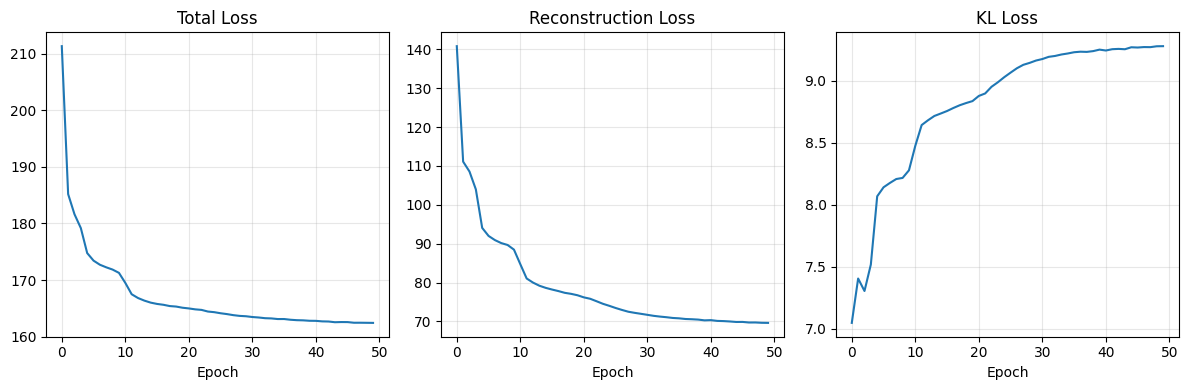

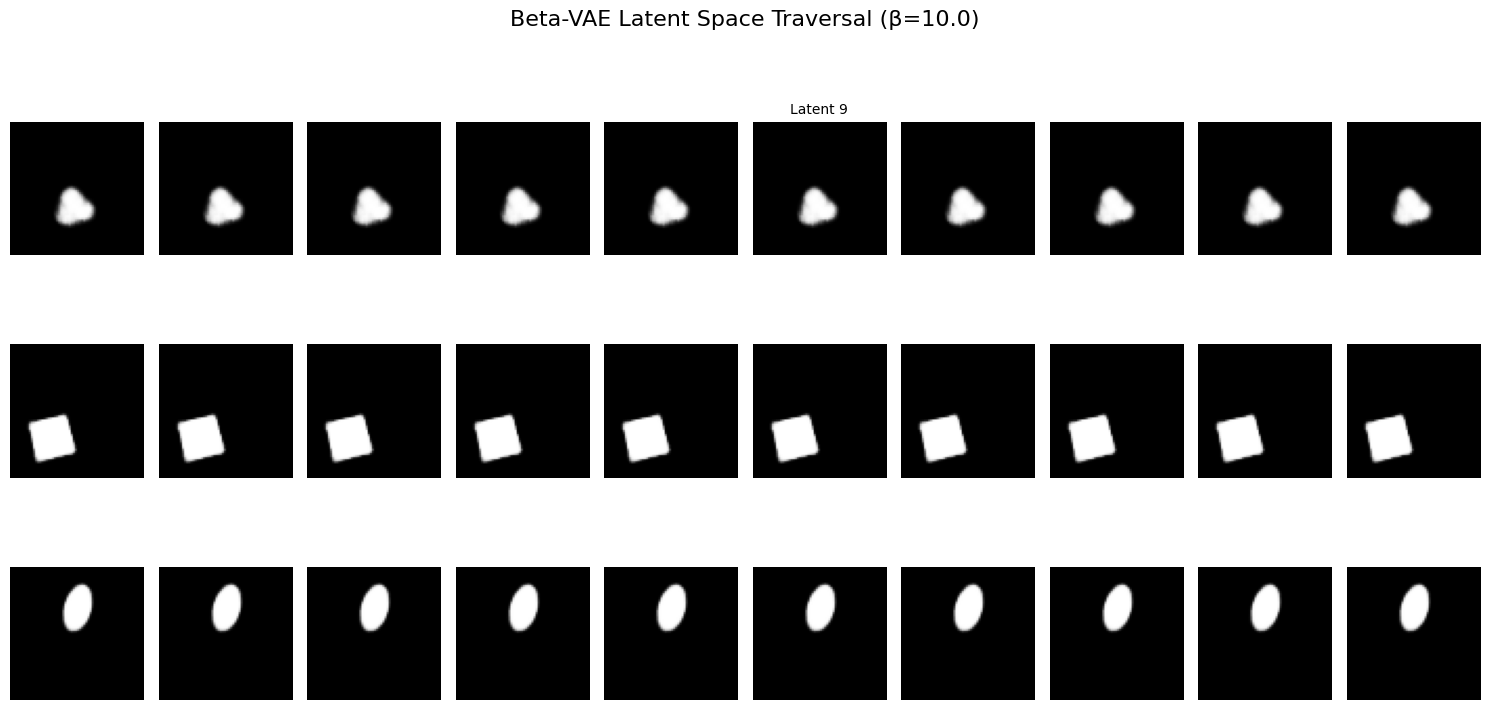

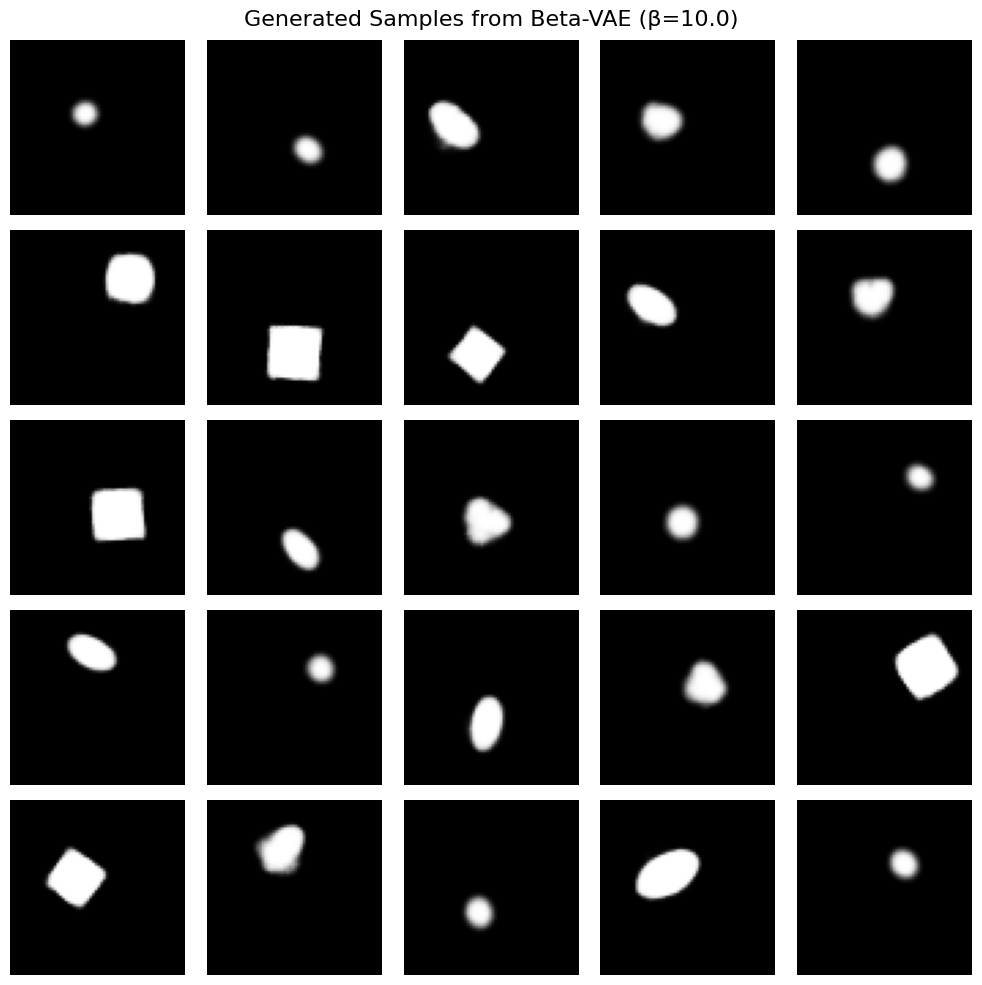

Variance of latent dimensions:
  Latent 0: 1.0084
  Latent 1: 0.0002
  Latent 2: 0.0001
  Latent 3: 1.0023
  Latent 4: 0.0002
  Latent 5: 0.9586
  Latent 6: 0.6327
  Latent 7: 0.0001
  Latent 8: 0.6360
  Latent 9: 0.0001


In [14]:
def main():
    """Main function to run Beta-VAE experiments"""

    # Load dataset
    print("Loading dataset...")
    try:
        # Try dSprites first
        images, latents, latents_classes = load_dsprites()
        dataset = DSpritesDataset(images)
        print("Using dSprites dataset")
    except:
        # Fall back to CelebA
        print("dSprites not available, using CelebA")
        dataset = load_celeba()

    # Create data loaders
    train_size = int(0.9 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    print(f"Training samples: {len(train_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

    # Experiment with different beta values
    beta_values = [1.0, 4.0, 10.0]

    for beta in beta_values:
        print(f"\n{'='*60}")
        print(f"Training Beta-VAE with β={beta}")
        print(f"{'='*60}")

        # Initialize model
        model = BetaVAE(z_dim=10, beta=beta, input_channels=1)

        # Train
        train_losses, recon_losses, kl_losses = train_beta_vae(
            model, train_loader, epochs=50, learning_rate=1e-3
        )

        # Visualize results
        plot_training_curves(train_losses, recon_losses, kl_losses)
        latent_traversal(model, test_loader, num_samples=3, traversal_steps=10)
        generate_random_samples(model, num_samples=25)

        # Compute metrics if we have true latent factors (dSprites)
        if 'latents' in locals():
            compute_disentanglement_metrics(model, test_loader, latents)

if __name__ == "__main__":
    main()